# [프로젝트4] 문의 유형 분류를 위해 Attention이 추가된 RNN 기반 모델 적용하기

---


## 프로젝트 목표
---
- 기존 LSTM 모델에 Attention을 추가한 모델 구성
- Attention을 통한 결과 분석


## 프로젝트 목차
---

1. **Attention을 추가한 LSTM 구성:** 프로젝트 2에서 구성한 LSTM에 Attention 모듈을 추가합니다.

2. **Attention을 통한 결과 분석:** Attention이 추가된 LSTM을 학습하고 결과를 분석합니다.


## 프로젝트 개요
---

프로젝트 3에서 LSTM 모델을 구성하고 학습하여 분류 모델을 만들었습니다. 이번 프로젝트에서는 Attention 모듈을 LSTM에 추가해보도록 하겠습니다. 그리고 추가한 모듈이 어떤 효과를 가져다 주는지 확인합니다.

## 1. 데이터 전처리

---

### 1.1. 라이브러리 및 데이터 불러오기


프로젝트 1에서 사용한 데이터와 모델 학습을 위해 필요한 라이브러리를 불러옵니다. 

In [1]:
!pip install torch torchtext==0.11.0

     |████████████████████████████████| 8.0 MB 15.8 MB/s eta 0:00:01
     |███████████▌                    | 318.0 MB 142.1 MB/s eta 0:00:04

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)




     |████████████████▌               | 455.6 MB 149.6 MB/s eta 0:00:03
     |████████████████▌               | 455.7 MB 149.6 MB/s eta 0:00:03
     |████████████████▌               | 455.7 MB 149.6 MB/s eta 0:00:03
     |████████████████▌               | 455.7 MB 149.6 MB/s eta 0:00:03
     |████████████████▌               | 455.7 MB 149.6 MB/s eta 0:00:03
     |████████████████▌               | 455.7 MB 149.6 MB/s eta 0:00:03
     |████████████████▌               | 455.7 MB 149.6 MB/s eta 0:00:03
     |████████████████▌               | 455.7 MB 149.6 MB/s eta 0:00:03
     |████████████████▌               | 455.7 MB 149.6 MB/s eta 0:00:03
     |████████████████▌               | 455.7 MB 149.6 MB/s eta 0:00:03
     |████████████████▌               | 455.8 MB 149.6 MB/s eta 0:00:03
     |████████████████▌               | 455.8 MB 149.6 MB/s eta 0:00:03
     |████████████████▌               | 455.8 MB 149.6 MB/s eta 0:00:03
     |████████████████▌               | 455.8 MB 149.6 MB/s eta

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)




     |████████████████████████████████| 879.7 MB 146.1 MB/s eta 0:00:01
     |████████████████████████████████| 879.7 MB 146.1 MB/s eta 0:00:01
     |████████████████████████████████| 879.7 MB 146.1 MB/s eta 0:00:01
     |████████████████████████████████| 879.7 MB 146.1 MB/s eta 0:00:01
     |████████████████████████████████| 879.7 MB 146.1 MB/s eta 0:00:01
     |████████████████████████████████| 879.7 MB 146.1 MB/s eta 0:00:01
     |████████████████████████████████| 879.7 MB 146.1 MB/s eta 0:00:01
     |████████████████████████████████| 879.8 MB 146.1 MB/s eta 0:00:01
     |████████████████████████████████| 879.8 MB 146.1 MB/s eta 0:00:01
     |████████████████████████████████| 879.8 MB 146.1 MB/s eta 0:00:01
     |████████████████████████████████| 879.8 MB 146.1 MB/s eta 0:00:01
     |████████████████████████████████| 879.8 MB 146.1 MB/s eta 0:00:01
     |████████████████████████████████| 879.8 MB 146.1 MB/s eta 0:00:01
     |████████████████████████████████| 879.8 MB 146.1 MB/s eta

In [2]:
import pandas as pd
import re
from konlpy.tag import Okt

import random
import numpy as np
import torch
import torchtext

In [3]:
data = pd.read_csv('./01_data.csv', encoding='cp949')
texts = data['메모'].tolist() # 자연어 데이터를 리스트 형식으로 변환합니다
label_list = data['상담유형3_GT'].unique().tolist()
labels = data['상담유형3_GT'].tolist()

In [4]:
def cleaning(text):
    # 정제: 한글, 공백 제외한 문자 제거
    text = re.sub('[^가-힣ㄱ-ㅎㅏ-ㅣ\\s]', '', text)
    return text

In [5]:
texts_clean = []
for i in range(len(texts)):
    text_clean = cleaning(texts[i])
    texts_clean.append(text_clean)

학습 데이터와 테스트 데이터를 구분합니다.

In [6]:
num_train = int(0.8*len(texts_clean))

texts_labels = list(zip(texts_clean,labels))
random.shuffle(texts_labels)
texts_clean, labels = zip(*texts_labels)

train_texts = texts_clean[:num_train]
train_labels = labels[:num_train]

test_texts = texts_clean[num_train:]
test_labels = labels[num_train:]

In [7]:
train_data = pd.DataFrame({'text': train_texts,
                          'label': train_labels})
test_data = pd.DataFrame({'text': test_texts,
                          'label': test_labels})

In [8]:
train_data.to_csv('./train_data.csv',index=False)
test_data.to_csv('./test_data.csv',index=False)

### 1.2. 데이터 전처리
---

List 형태로 저장되어 있는 데이터와 라벨을 torch 모델에 적용할 수 있도록 전처리합니다. 이때, torchtext 라이브러리를 사용합니다.

In [9]:
tokenizer = Okt()

TEXT = torchtext.legacy.data.Field(tokenize=tokenizer.morphs,
                 include_lengths=True)

LABEL = torchtext.legacy.data.LabelField(dtype=torch.long)

fields = {'text': ('text', TEXT), 'label': ('label', LABEL)}

train, validation, test 데이터를 구분지어 만듭니다.

In [10]:
train_data, test_data = torchtext.legacy.data.TabularDataset.splits(
                            path = './',
                            train = 'train_data.csv',
                            test = 'test_data.csv',
                            format = 'csv',
                            fields = fields,  
)

In [11]:
train_data, valid_data = train_data.split()

자연어 데이터를 컴퓨터로 표현하기 위한 임베딩 벡터를 가져옵니다. 본 프로젝트에서는 한국어 임베딩이 있는 FastText 서브 워드 임베딩을 사용합니다.

In [12]:
TEXT.build_vocab(train_data,
                 max_size = 10000,
                 vectors = 'fasttext.simple.300d',
                 unk_init = torch.Tensor.normal_)

LABEL.build_vocab(train_data)

.vector_cache/wiki.simple.vec: 293MB [00:36, 7.96MB/s]                               
100%|██████████| 111051/111051 [00:08<00:00, 13126.19it/s]


In [13]:
batch_size = 64

device = torch.device('cpu')

train_iterator, valid_iterator, test_iterator = torchtext.legacy.data.BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size = batch_size,
    sort_key = lambda x: len(x.text),
    sort_within_batch = True,
    device = device)

## 2. Attention이 추가된 LSTM 모델 구성

---

Attention이 추가된 LSTM 분류 모델을 torch로 구성합니다.


In [14]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

### [TODO] Attention 모듈을 만드는 코드를 작성해 주세요.

In [15]:
class AttnLSTMClassifier(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size, pad_idx):
        super(AttnLSTMClassifier, self).__init__()
        # 단어 임베딩
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        # LSTM
        self.lstm = nn.LSTM(embedding_dim, hidden_dim)
        # 분류자 (classifier)
        self.fc = nn.Linear(hidden_dim, tagset_size)
    
    # attention 모듈을 추가합니다.
    def attention(self, lstm_output, final_state):
        lstm_output = lstm_output.transpose(0, 1)
        hidden = final_state.squeeze(0)
        attn_score = torch.bmm(lstm_output, hidden.unsqueeze(2)).squeeze(2)
 # attention score를 계산합니다.
        attn_dist = F.softmax(attn_score, 1) # 확률 값으로 나오는 attention distribution을 계산합니다.
        attn_output = torch.bmm(lstm_output.transpose(1, 2), attn_dist.unsqueeze(2)).squeeze(2)
 # attention output을 계산합니다.
        
        return attn_output, attn_dist
    
    def forward(self, text, text_length, give_attn=False):
        embeds = self.word_embeddings(text)
        packed_embeds = nn.utils.rnn.pack_padded_sequence(embeds, text_length)
        packed_output, (hidden, cell) = self.lstm(packed_embeds)
        lstm_output, output_length = nn.utils.rnn.pad_packed_sequence(packed_output)
        
        # attention 모듈을 적용합니다.
        attn_output, attn_dist = self.attention(lstm_output, lstm_output[-1])
        
        logits = self.fc(attn_output)
        scores = F.log_softmax(logits, dim=1)
        
        if give_attn:
            return scores, attn_dist
        else:
            return scores

## 3. Attention이 추가된 LSTM을 통한 문의 유형 분류 문제

---

### 3.1 하이퍼파라미터 설정


In [16]:
VOCAB_SIZE = len(TEXT.vocab) # 단어 개수
EMBEDDING_DIM = 300 # 임베딩 차원
HIDDEN_DIM = 256 # 은닉 상태 차원
TARGET_SIZE = len(LABEL.vocab.stoi) # 라벨 클래스 개수
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token] # 패딩 인덱스


### 3.2 모델 학습

모델, 손실 함수 (loss function), 옵티마이저 (optimizer) 설정

In [17]:
model = AttnLSTMClassifier(EMBEDDING_DIM, HIDDEN_DIM, VOCAB_SIZE, TARGET_SIZE, PAD_IDX)
loss_function = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

임베딩을 사전 학습된 FastText 임베딩으로 덮어씌웁니다.

In [18]:
pretrained_embeddings = TEXT.vocab.vectors
model.word_embeddings.weight.data.copy_(pretrained_embeddings) 

tensor([[-0.7143,  0.6447,  0.9299,  ..., -0.9402,  0.9062,  0.8655],
        [ 0.1939, -1.9608, -0.2909,  ...,  0.1188,  0.8066, -0.4780],
        [-0.7287,  0.6041,  0.6408,  ..., -0.3604, -0.2876, -0.6841],
        ...,
        [ 0.2491,  0.2438, -0.5939,  ...,  1.4618, -0.7488, -0.2354],
        [-0.0334,  0.4628, -0.0725,  ...,  0.6031, -0.2068,  0.0090],
        [ 0.8235,  1.1847, -0.3353,  ...,  0.4499,  0.6475, -0.4078]])

사전에 정의되지 않은 단어에 대한 토큰인 `<UNK>`와 빈 칸을 위한 토큰인 `<PAD>`를 0 벡터로 설정합니다.

In [19]:
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]
print(UNK_IDX, PAD_IDX)

model.word_embeddings.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.word_embeddings.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

print(model.word_embeddings.weight.data)

0 1
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.7287,  0.6041,  0.6408,  ..., -0.3604, -0.2876, -0.6841],
        ...,
        [ 0.2491,  0.2438, -0.5939,  ...,  1.4618, -0.7488, -0.2354],
        [-0.0334,  0.4628, -0.0725,  ...,  0.6031, -0.2068,  0.0090],
        [ 0.8235,  1.1847, -0.3353,  ...,  0.4499,  0.6475, -0.4078]])


정확도를 재는 함수를 정의합니다.

In [20]:
def accuracy(prediction, label):
    prediction_argmax = prediction.max(dim=-1)[1]
    correct = (prediction_argmax == label).float()
    acc = correct.sum() / len(correct)
    return acc

훈련 함수를 정의합니다.

In [21]:
def train(model, iterator, optimizer, loss_function):
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        optimizer.zero_grad()
        text, text_length = batch.text
        if 0. in text_length:
            continue
        predictions = model(text, text_length)
        
        loss = loss_function(predictions, batch.label)
        acc = accuracy(predictions, batch.label)
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

평가 함수를 정의합니다.

In [22]:
def evaluate(model, iterator, loss_function):
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
        for batch in iterator:
            text, text_length = batch.text
            if 0. in text_length:
                continue
            predictions = model(text, text_length)
            
            loss = loss_function(predictions, batch.label)
            acc = accuracy(predictions, batch.label)
            
            epoch_loss += loss.item()
            epoch_acc += acc.item()
    
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

학습을 진행합니다.

In [23]:
NUM_EPOCHS = 10
best_valid_loss = float('inf')

In [24]:
for epoch in range(NUM_EPOCHS):
    train_loss, train_acc = train(model, train_iterator, optimizer, loss_function)
    valid_loss, valid_acc = evaluate(model, valid_iterator, loss_function)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'attn-lstm-best.pt')
        
    print(f'Epoch: {epoch+1:02}')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01
	Train Loss: 2.382 | Train Acc: 25.56%
	 Val. Loss: 1.917 |  Val. Acc: 35.50%
Epoch: 02
	Train Loss: 1.749 | Train Acc: 40.26%
	 Val. Loss: 1.624 |  Val. Acc: 45.61%
Epoch: 03
	Train Loss: 1.434 | Train Acc: 52.40%
	 Val. Loss: 1.424 |  Val. Acc: 52.88%
Epoch: 04
	Train Loss: 1.148 | Train Acc: 63.33%
	 Val. Loss: 1.285 |  Val. Acc: 55.43%
Epoch: 05
	Train Loss: 0.930 | Train Acc: 70.96%
	 Val. Loss: 1.183 |  Val. Acc: 60.09%
Epoch: 06
	Train Loss: 0.786 | Train Acc: 76.21%
	 Val. Loss: 1.105 |  Val. Acc: 63.16%
Epoch: 07
	Train Loss: 0.620 | Train Acc: 80.05%
	 Val. Loss: 1.096 |  Val. Acc: 63.46%
Epoch: 08
	Train Loss: 0.510 | Train Acc: 83.40%
	 Val. Loss: 1.128 |  Val. Acc: 63.29%
Epoch: 09
	Train Loss: 0.423 | Train Acc: 86.03%
	 Val. Loss: 1.082 |  Val. Acc: 66.26%
Epoch: 10
	Train Loss: 0.336 | Train Acc: 88.87%
	 Val. Loss: 1.113 |  Val. Acc: 65.95%


테스트 데이터에 대하여 평가를 진행합니다.

In [25]:
model.load_state_dict(torch.load('attn-lstm-best.pt'))
test_loss, test_acc = evaluate(model, test_iterator, loss_function)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 1.093 | Test Acc: 62.19%


## 4. Attention을 통한 결과 분석

---
주어진 단어 토큰 중에 예측을 위하여 어떤 단어 토큰을 중요하게 생각하는지 Attention distribution 값을 출력시켜 확인합니다.

In [26]:
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib.font_manager as fm
import seaborn as sns

이미지에 한국어 적용을 위한 사전 설정입니다.

In [28]:
fm._rebuild()
fm.get_fontconfig_fonts()

font_location = './NanumSquareR.ttf'

font_name = fm.FontProperties(fname=font_location).get_name()
rc('font', family=font_name)
plt.rc('font', family='NanumSquare')

### [TODO] Attention Distribution을 시각화하는 함수 코드를 작성합니다.

In [29]:
def attn_visualization(model, iterator, num_examples):
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    exist_zero_length = True
    iterator = iter(iterator)
    with torch.no_grad():
        while exist_zero_length:
            batch = next(iterator)
            text, text_length = batch.text
            if 0. not in text_length:
                exist_zero_length = False
        predictions, attn_dists = model(text, text_length, give_attn=True)
 # attention distribution이 나올 수 있도록 모델 출력값을 만듭니다.
        predictions_argmax = predictions.max(dim=-1)[1] # 분류자가 예측한 라벨을 찾습니다.
        
        for i in range(num_examples):
            text_temp = np.array(TEXT.vocab.itos)[text[:, i]]
            true_label = LABEL.vocab.itos[batch.label[i]]
            predicted_label = LABEL.vocab.itos[predictions_argmax[i]]
            attn_dist = attn_dists[i].numpy()
            
            if true_label == predicted_label:
                df_vis = pd.DataFrame(data=attn_dist[None, :], columns=text_temp, index=[0])
                f, ax = plt.subplots(figsize=(10,1))
                sns.heatmap(df_vis, vmin=0., vmax=1., ax=ax, cmap="OrRd")
                label_x = ax.get_xticklabels()
                plt.setp(label_x, rotation=45, horizontalalignment='right')
                plt.show()
                plt.clf()

                print('Text : ', text_temp)
                print('True Label : ', true_label)
                print('Predicted : ', predicted_label)
                print('Attention Distribution : ', attn_dist)
                print('='*50)

findfont: Font family ['NanumSquare'] not found. Falling back to DejaVu Sans.
/opt/conda/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 53685 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 54868 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 51473 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 45824 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 44592 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.8/site-packages/matplotlib/backends/backend_

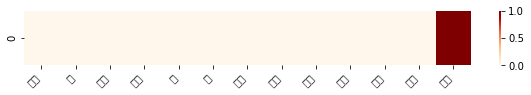

/opt/conda/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 50668 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 54620 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 45804 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 51204 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 48512 missing from current font.
  font.set_

Text :  ['통화' '중' '대기' '미적' '용' '재' '등록' '동일' '타사' '단말' '특성' '양해' '종료']
True Label :  통화중대기
Predicted :  통화중대기
Attention Distribution :  [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.001
 0.998]


<Figure size 432x288 with 0 Axes>

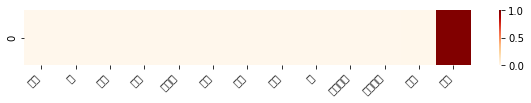

Text :  ['여수' '한' '달전' '부터' '데이터' '접속' '불가' '통화' '는' '모르겠음' '와이파이' '전원' '리셋']
True Label :  초기접속불가
Predicted :  초기접속불가
Attention Distribution :  [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.006
 0.994]


/opt/conda/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 45130 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 44608 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 47928 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 51032 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 52488 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 50728 missing from current font.
  font.set_

<Figure size 432x288 with 0 Axes>

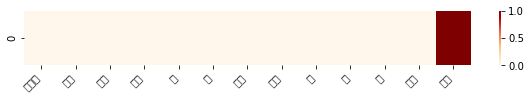

Text :  ['데이터' '끊김' '문의' '초기' '화' '온' '오프' '안내' '지' '속' '시' '점검' '안내']
True Label :  데이터 사용중 끊김
Predicted :  데이터 사용중 끊김
Attention Distribution :  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


/opt/conda/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 51109 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 48708 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 49444 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 54980 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 51613 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 49345 missing from current font.
  font.set_

<Figure size 432x288 with 0 Axes>

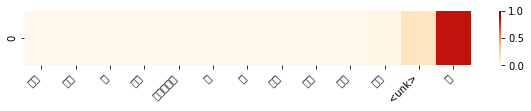

Text :  ['장비' '시설' '후' '증상' '동일하다고' '하' '심' '구축' '으로' '내용' '전달' '<unk>' '티']
True Label :  통품상담성
Predicted :  통품상담성
Attention Distribution :  [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.019 0.156
 0.825]


/opt/conda/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 45720 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 44049 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 51088 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 48152 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 51221 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 54588 missing from current font.
  font.set_

<Figure size 432x288 with 0 Axes>

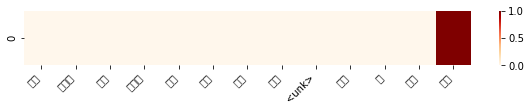

Text :  ['오늘' '갑자기' '일반' '데이터' '정상' '음성' '정상' '피망' '<unk>' '어플' '이' '자꾸' '끊김']
True Label :  기타 Application
Predicted :  기타 Application
Attention Distribution :  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


/opt/conda/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 46104 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 49689 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 51228 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 46104 missing from current font.
  font.set_text(s, 0, flags=flags)
/opt/conda/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 49689 missing from current font.
  font.set_text(s, 0, flags=flags)
/opt/conda/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 51228 missing from current font.
  font.set_text

<Figure size 432x288 with 0 Axes>

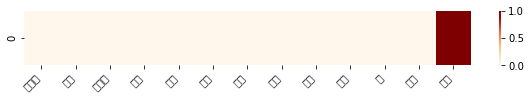

Text :  ['데이터' '이용' '안되어' '문의' '기기' '사용' '미숙' '제한' '설정' '해제' '후' '사용' '안내']
True Label :  초기접속불가
Predicted :  초기접속불가
Attention Distribution :  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


/opt/conda/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 51064 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 49888 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 51096 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 46108 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 54632 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 51064 missing from current font.
  font.set_

<Figure size 432x288 with 0 Axes>

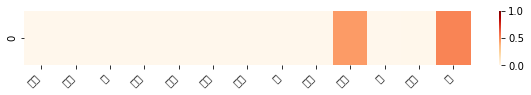

Text :  ['인증' '문자' '수' '신안' '되어' '문의' '통화' '중' '문자' '수신' '잘' '된다' '함']
True Label :  기업형메시지(금융권인증SMS)
Predicted :  기업형메시지(금융권인증SMS)
Attention Distribution :  [0.    0.    0.    0.    0.    0.    0.    0.    0.001 0.463 0.    0.005
 0.531]


/opt/conda/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 52972 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 47084 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 47553 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 49828 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 54072 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 50640 missing from current font.
  font.set_

<Figure size 432x288 with 0 Axes>

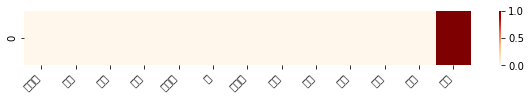

Text :  ['컬러링' '인증' '문자' '수신' '안된다' '함' '스팸함' '에서' '확인' '되어' '해제' '방법' '안내']
True Label :  기업형메시지(금융권인증SMS)
Predicted :  기업형메시지(금융권인증SMS)
Attention Distribution :  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


/opt/conda/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 49892 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 54056 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 50630 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 44428 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 50976 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 46300 missing from current font.
  font.set_

<Figure size 432x288 with 0 Axes>

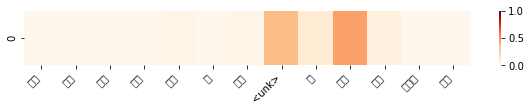

Text :  ['인증' '문자' '수신' '실패' '확인' '시' '없음' '<unk>' '로' '문의' '권유' '드리고' '종료']
True Label :  기업형메시지(금융권인증SMS)
Predicted :  기업형메시지(금융권인증SMS)
Attention Distribution :  [0.    0.    0.    0.    0.023 0.    0.021 0.365 0.09  0.447 0.052 0.
 0.001]


<Figure size 432x288 with 0 Axes>

In [30]:
num_examples = 10
np.set_printoptions(precision=3, suppress=True)
attn_visualization(model, test_iterator, num_examples)